In [1]:
library(fda)

Loading required package: splines

Loading required package: fds

Loading required package: rainbow

Loading required package: MASS

Loading required package: pcaPP

Loading required package: RCurl

Loading required package: deSolve


Attaching package: 'fda'


The following object is masked from 'package:graphics':

    matplot




In [2]:
library(lubridate)


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [3]:
library(tidyverse)

-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr   1.1.2     v readr   2.1.4
v forcats 1.0.0     v stringr 1.5.0
v ggplot2 3.4.2     v tibble  3.2.1
v purrr   1.0.1     v tidyr   1.3.0
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x tidyr::complete() masks RCurl::complete()
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks stats::lag()
x dplyr::select()   masks MASS::select()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
library(IRdisplay)

## 2.2  Penalized smoothing

6/30の気温データに完璧に適合した関数  
7/1 の気温データを予測するには不適切  
2つはほぼ同じ関数から発生したデータのはずが全く異なる関数が出来上がる

In [5]:
getwd()

[1] "C:/Users/Kenta/ProgramScripts/Piotr_FunctionalDataAnalysis/ch2"

In [6]:
list.files(getwd())

[1] "222_canadatemp.png"   "223_canadatemp.png"   "224_canadatemp.png"  
[4] "225_canadatemp.png"   "226_canadatemp.png"   "ch2.ipynb"           
[7] "images"               "Matern_process.ipynb" "sample_temp.csv"

In [7]:
file.rename("data.csv", "sample_temp.csv")

Warning message in file.rename("data.csv", "sample_temp.csv"):
"cannot rename file 'data.csv' to 'sample_temp.csv', reason 'The system cannot find the file specified'"


[1] FALSE

In [8]:
list.files(getwd())

[1] "222_canadatemp.png"   "223_canadatemp.png"   "224_canadatemp.png"  
[4] "225_canadatemp.png"   "226_canadatemp.png"   "ch2.ipynb"           
[7] "images"               "Matern_process.ipynb" "sample_temp.csv"

In [9]:
sample_temp = read.csv("sample_temp.csv", header=FALSE,skip=5)
head(sample_temp)

,V1,V2,V3,V4
,<chr>,<dbl>,<int>,<int>
1,2023/5/16 1:00:00,13.1,8,1
2,2023/5/16 2:00:00,13.5,8,1
3,2023/5/16 3:00:00,13.1,8,1
4,2023/5/16 4:00:00,12.4,8,1
5,2023/5/16 5:00:00,12.7,8,1
6,2023/5/16 6:00:00,13.6,8,1


In [10]:
nrow(sample_temp)

[1] 48

In [11]:
sample_temp = sample_temp[,c( -3,-4)]
sample_temp = sample_temp[-nrow(sample_temp),]
colnames(sample_temp)= c("datetime", "temp")
head(sample_temp)

,datetime,temp
,<chr>,<dbl>
1,2023/5/16 1:00:00,13.1
2,2023/5/16 2:00:00,13.5
3,2023/5/16 3:00:00,13.1
4,2023/5/16 4:00:00,12.4
5,2023/5/16 5:00:00,12.7
6,2023/5/16 6:00:00,13.6


In [12]:
sample_temp$datetime = ymd_hms(sample_temp$datetime)
sample_temp$date = date(sample_temp$datetime)

In [13]:
head(sample_temp)
tail(sample_temp)

,datetime,temp,date
,<dttm>,<dbl>,<date>
1,2023-05-16 01:00:00,13.1,2023-05-16
2,2023-05-16 02:00:00,13.5,2023-05-16
3,2023-05-16 03:00:00,13.1,2023-05-16
4,2023-05-16 04:00:00,12.4,2023-05-16
5,2023-05-16 05:00:00,12.7,2023-05-16
6,2023-05-16 06:00:00,13.6,2023-05-16


,datetime,temp,date
,<dttm>,<dbl>,<date>
42,2023-05-17 18:00:00,27.1,2023-05-17
43,2023-05-17 19:00:00,23.4,2023-05-17
44,2023-05-17 20:00:00,20.7,2023-05-17
45,2023-05-17 21:00:00,19.8,2023-05-17
46,2023-05-17 22:00:00,19.1,2023-05-17
47,2023-05-17 23:00:00,18.5,2023-05-17


Saving 6.67 x 6.67 in image


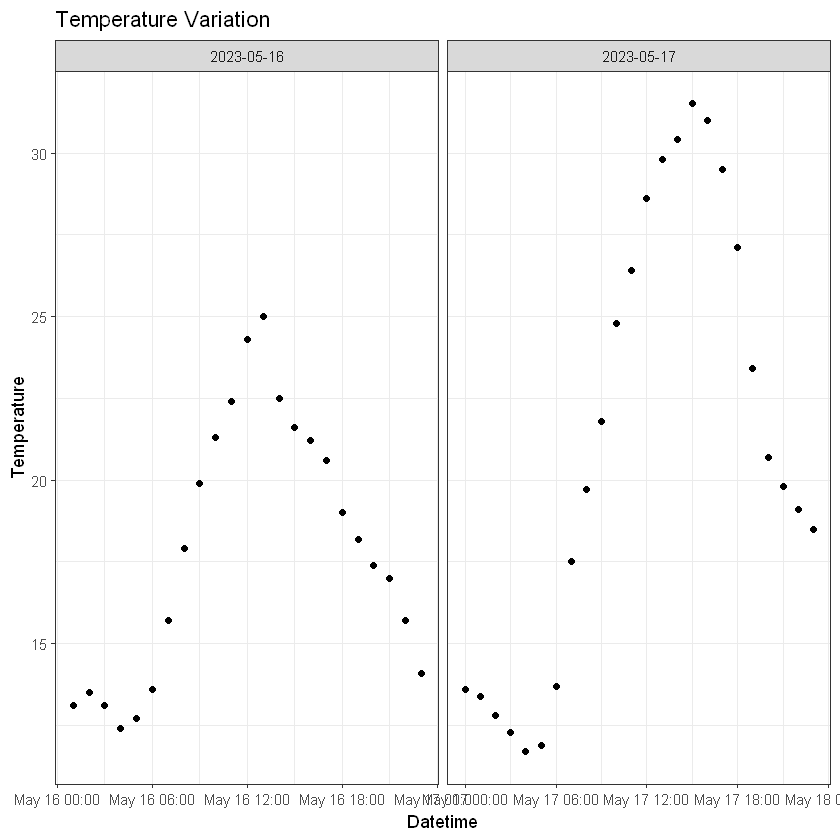

In [14]:
pic = sample_temp %>%
  ggplot(aes(x = datetime, y = temp)) +
  geom_point() +
  facet_wrap(~ date, scales = "free_x") +
  theme_bw() +
  labs(title = "Temperature Variation", x = "Datetime", y = "Temperature")

print(pic)
ggsave("./images/221_sample_temp.png")

### CanadianWeather

In [15]:
CanadianWeather

,N.latitude,W.longitude
St. Johns,47.34000,52.430
Halifax,44.39000,63.360
Sydney,46.09000,60.110
Yarmouth,43.50000,66.070
Charlottvl,42.48000,80.250
Fredericton,45.58000,66.390
Scheffervll,54.47000,64.490
Arvida,48.26000,71.110
Bagottville,48.21000,70.530
Quebec,46.49000,71.130


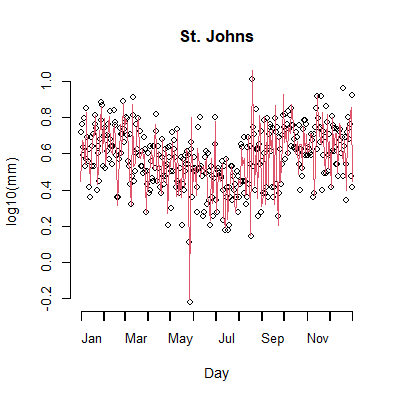

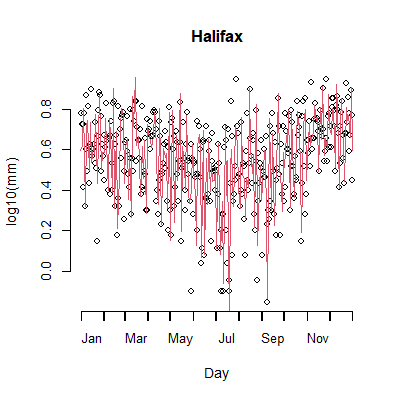

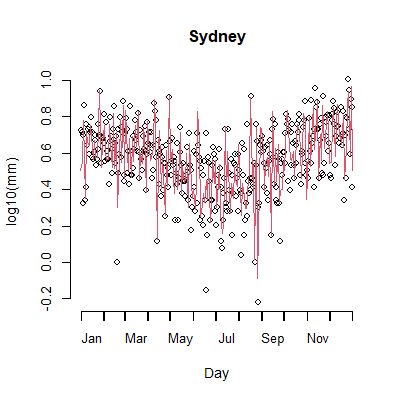

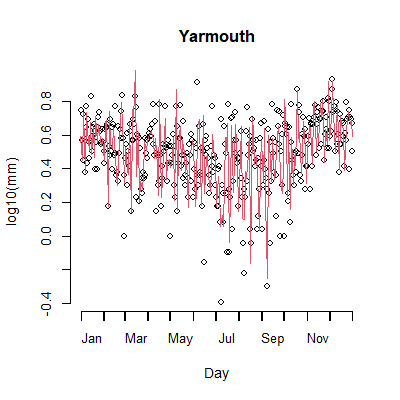

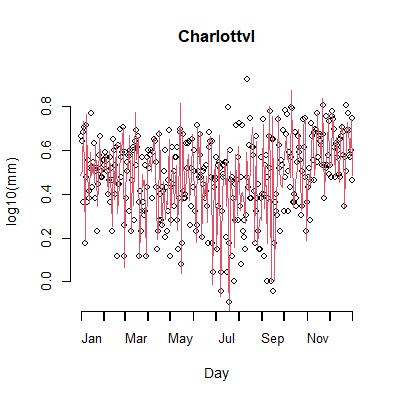

In [16]:
nbasis=365
yearRng = c(0, 365)
daybasis = create.fourier.basis(yearRng, nbasis)
logprecav = CanadianWeather$dailyAv[,,'log10precip']
dayprecfd = with(CanadianWeather, smooth.basis(day.5, logprecav, daybasis, fdnames=list("Day", "Station", "log10(mm)"))$fd)
for(i in 1:5){
    pngname=paste0("./images/22",i+1,"_canadatemp.png")
    png(pngname, width=400, height = 400) 
    par(cex=1.2)
    plot(logprecav[,i], axes=FALSE, xlab="Day", ylab="log10(mm)", main=CanadianWeather$place[i])
    lines(dayprecfd[i], col=2)
    axisIntervals(1)
    axis(2)

    dev.off()
    png_data <- readBin(pngname, "raw", file.size(pngname))
    display_png(png_data)

}

In [17]:
Lcoef = c(0, (2*pi/diff(yearRng))**2, 0.1)
harmaccelLfd= vec2Lfd(Lcoef, yearRng)

In [18]:
Lcoef
harmaccelLfd

[1] 0.0000000000 0.0002963289 0.1000000000

$call
Lfd(nderiv = m, bwtlist = bwtlist)

$nderiv
[1] 3

$bwtlist
$bwtlist[[1]]
$coefs
     reps 1
time      0

$basis
$call
basisfd(type = type, rangeval = rangeval, nbasis = nbasis, params = params, 
    dropind = dropind, quadvals = quadvals, values = values, 
    basisvalues = basisvalues)

$type
[1] "const"

$rangeval
[1]   0 365

$nbasis
[1] 1

$params
[1] 0

$dropind
numeric(0)

$quadvals
numeric(0)

$values
list()

$basisvalues
list()

$names
[1] "const"

attr(,"class")
[1] "basisfd"

$fdnames
$fdnames$args
[1] "time"

$fdnames$reps
[1] "reps 1"

$fdnames$funs
[1] "values"


attr(,"class")
[1] "fd"

$bwtlist[[2]]
$coefs
           reps 1
time 0.0002963289

$basis
$call
basisfd(type = type, rangeval = rangeval, nbasis = nbasis, params = params, 
    dropind = dropind, quadvals = quadvals, values = values, 
    basisvalues = basisvalues)

$type
[1] "const"

$rangeval
[1]   0 365

$nbasis
[1] 1

$params
[1] 0

$dropind
numeric(0)

$quadvals
numeric(0)

$values
list()

$basisvalues

log10 lambda = 4 
log10 lambda = 5 
log10 lambda = 6 
log10 lambda = 7 
log10 lambda = 8 
log10 lambda = 9 


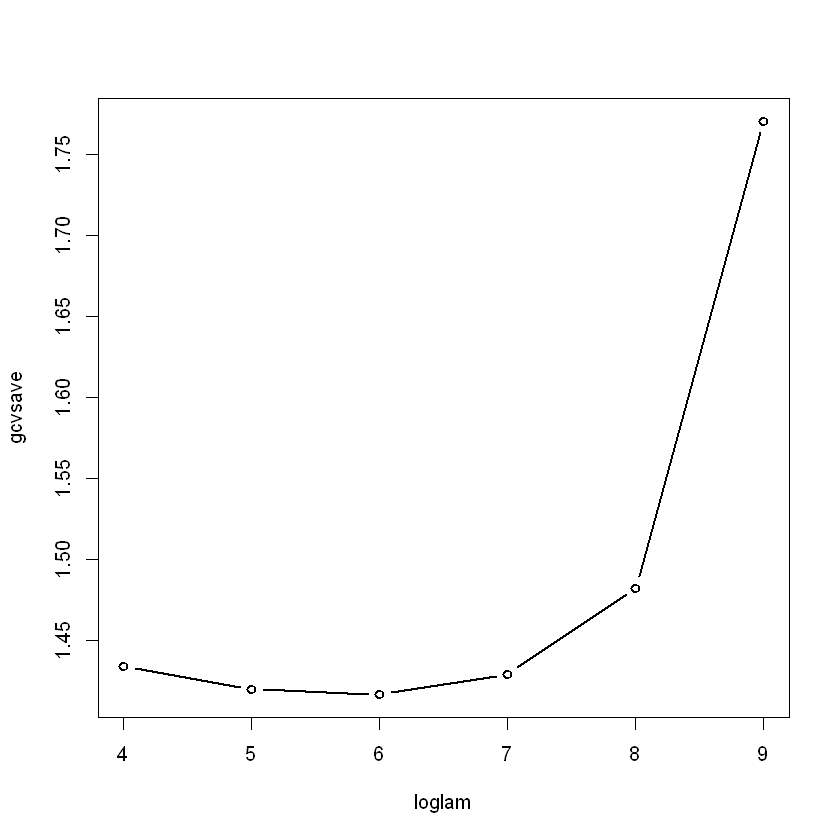

In [19]:
loglam = 4:9
nlam = length(loglam)
dfsave = rep(NA, nlam)
names(dfsave) = loglam
gcvsave = dfsave
for (ilam in 1:nlam) {
    cat(paste("log10 lambda =", loglam[ilam],'\n'))
    lambda = 10**loglam[ilam]
    fdParobj = fdPar(daybasis, harmaccelLfd, lambda)
    smoothlist = smooth.basis(day.5, logprecav, fdParobj)
    dfsave[ilam] = smoothlist$df
    gcvsave[ilam] = sum(smoothlist$gcv)
}

plot(loglam,gcvsave, type='b', lwd=2)

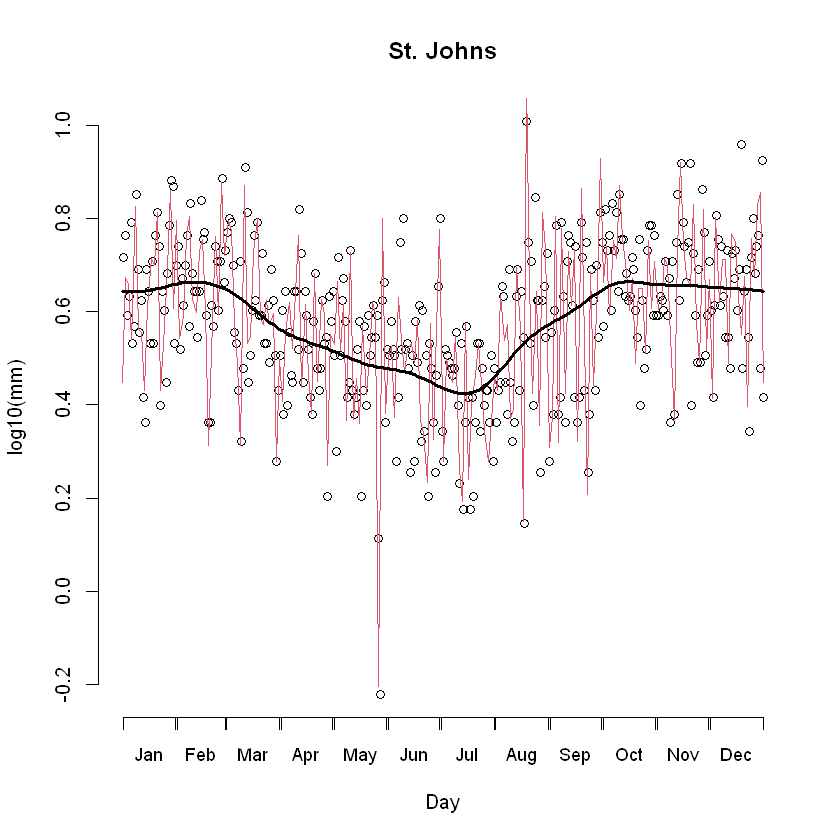

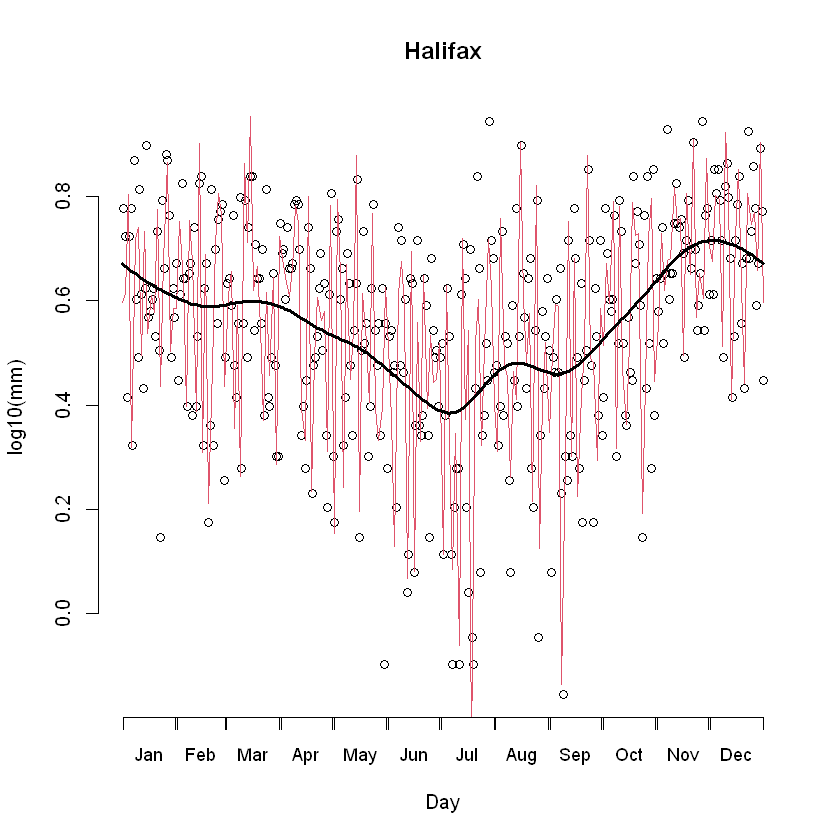

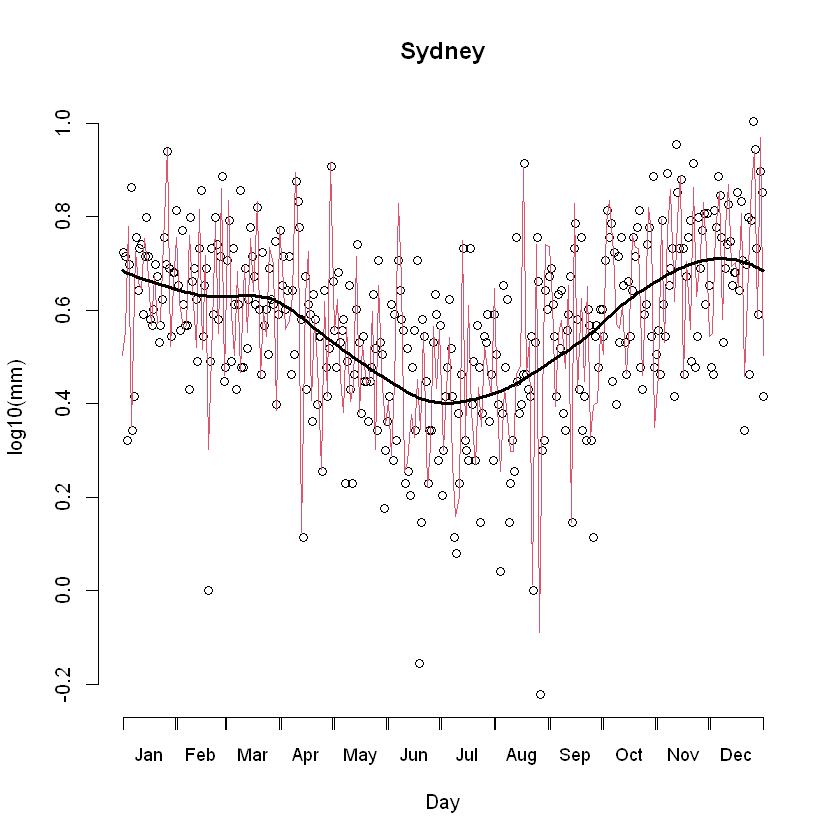

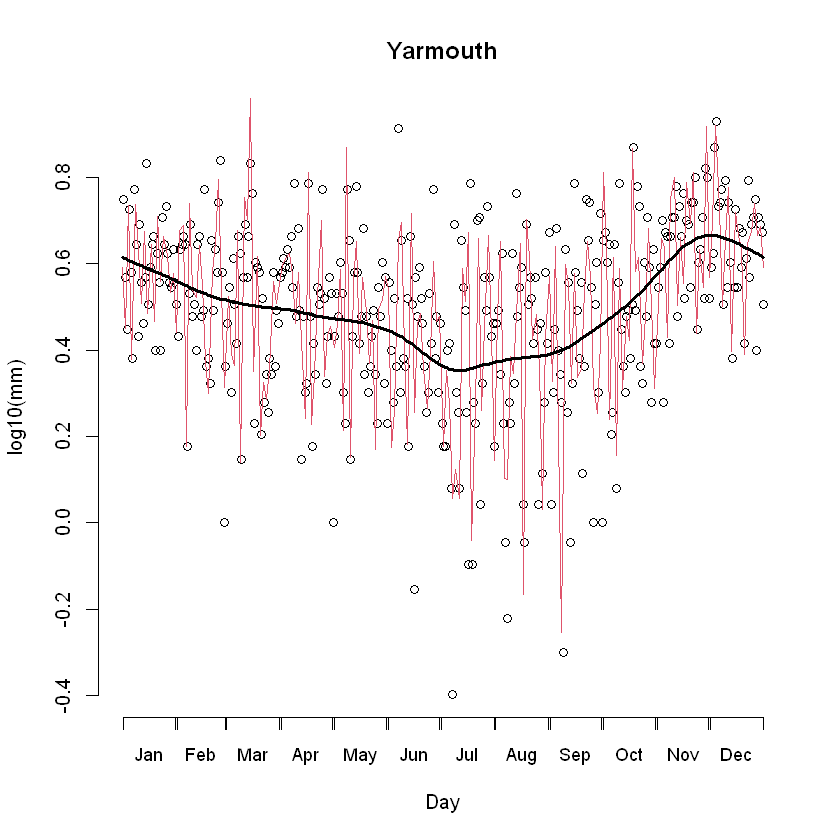

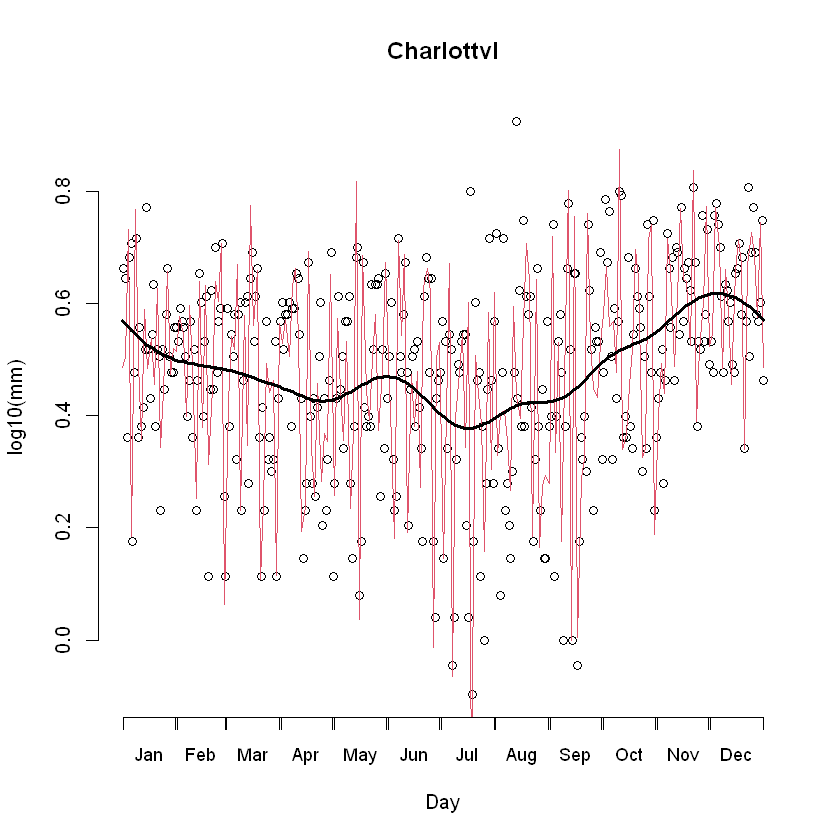

In [33]:
lambda = 1e6
fdParobj =fdPar(daybasis, harmaccelLfd, lambda)
logprec.fit = smooth.basis(day.5, logprecav, fdParobj)
logprec.fd = logprec.fit$fd
fdnames = list("Day (July 1 to June 30)", "Weather Station"=CanadianWeather$place, "Log 10 Precipitation(mm)")
logprec.fd$fdnames = fdnames

for(i in 1:5) {
    plot(logprecav[,i], axes=FALSE, xlab="Day", ylab="log10(mm)", main=CanadianWeather$place[i])
    lines(dayprecfd[i], col=2)
    axisIntervals(1)
    axis(2)
    lines(logprec.fd[i], lwd=3)
}

[1] "done"

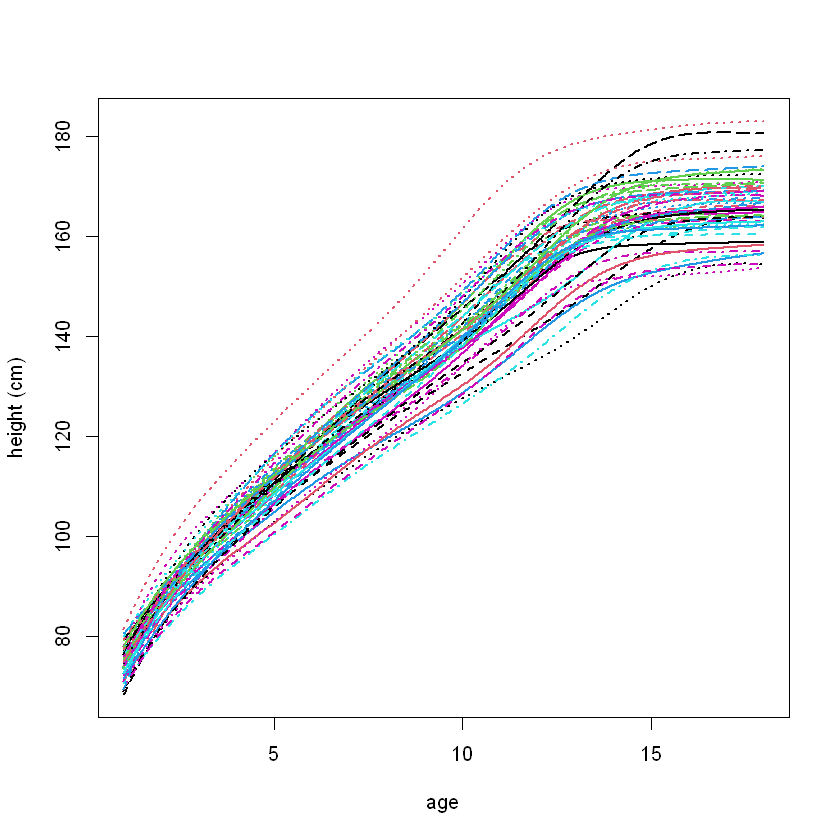

In [21]:
age = growth$age
heightBasis = create.bspline.basis(c(1,18), 35, 6, age)
heightPar = fdPar(heightBasis, 3, 10**(-0.5))
heightSmooth = smooth.basis(age, growth$hgtf, heightPar)
plot(heightSmooth, lwd=2, xlab="age", ylab="height (cm)")

[1] "done"

Warning message in mean.default(accelUnreg):
"argument is not numeric or logical: returning NA"


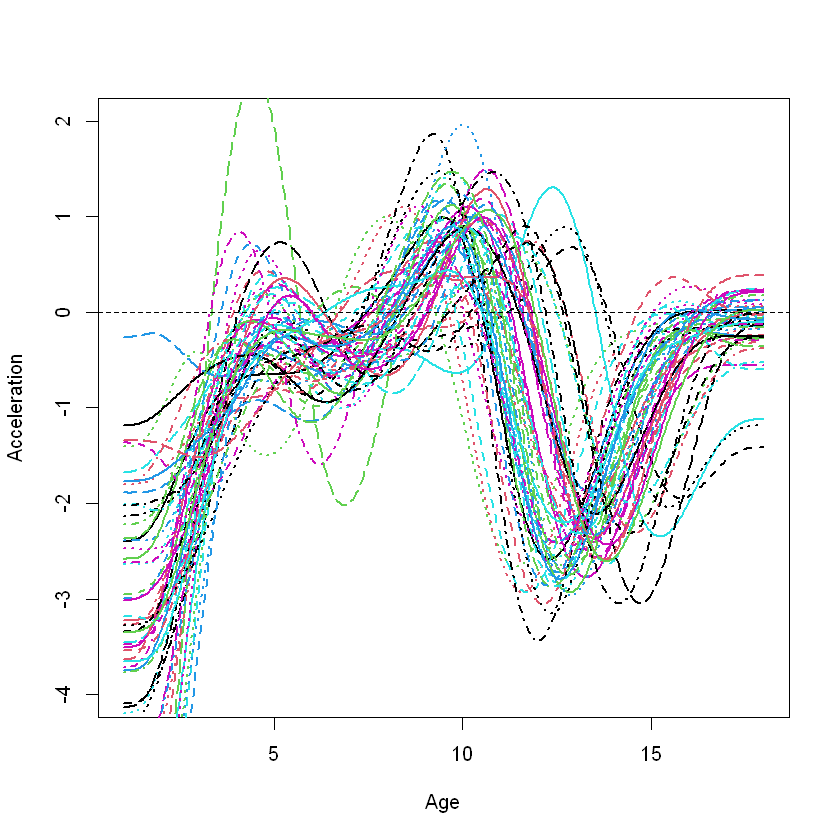

In [19]:
accelUnreg = deriv.fd(heightSmooth$fd, 2)
plot(accelUnreg[,1], lwd=2, xlab="Age", ylab="Acceleration", ylim=c(-4,2))
mean.accelUnreg = mean(accelUnreg)
lines(mean.accelUnreg, lwd=4, col="black")



-------  Curve  1   --------

Iter.    Criterion   Grad Length
0        0.3291      0.8613
1        0.1747      2e-04
2        0.1747      2e-04

-------  Curve  2   --------

Iter.    Criterion   Grad Length
0        0.2136      0.3625
1        0.1716      0.0033
2        0.1715      9e-04

-------  Curve  3   --------

Iter.    Criterion   Grad Length
0        1.4138      1.4097
1        0.5565      0.0357
2        0.5565      0.0357
3        0.5565      0.0344

-------  Curve  4   --------

Iter.    Criterion   Grad Length
0        0.1723      0.361
1        0.1237      0.0134
2        0.1236      1e-04
3        0.1236      1e-04

-------  Curve  5   --------

Iter.    Criterion   Grad Length
0        0.3813      0.8955
1        0.1668      0.0063
2        0.1667      5e-04
3        0.1667      5e-04

-------  Curve  6   --------

Iter.    Criterion   Grad Length
0        0.1239      0.0509
1        0.1233      0.0017
2        0.1233      3e-04

-------  Curve  7   --------

Iter.

[1] "done"

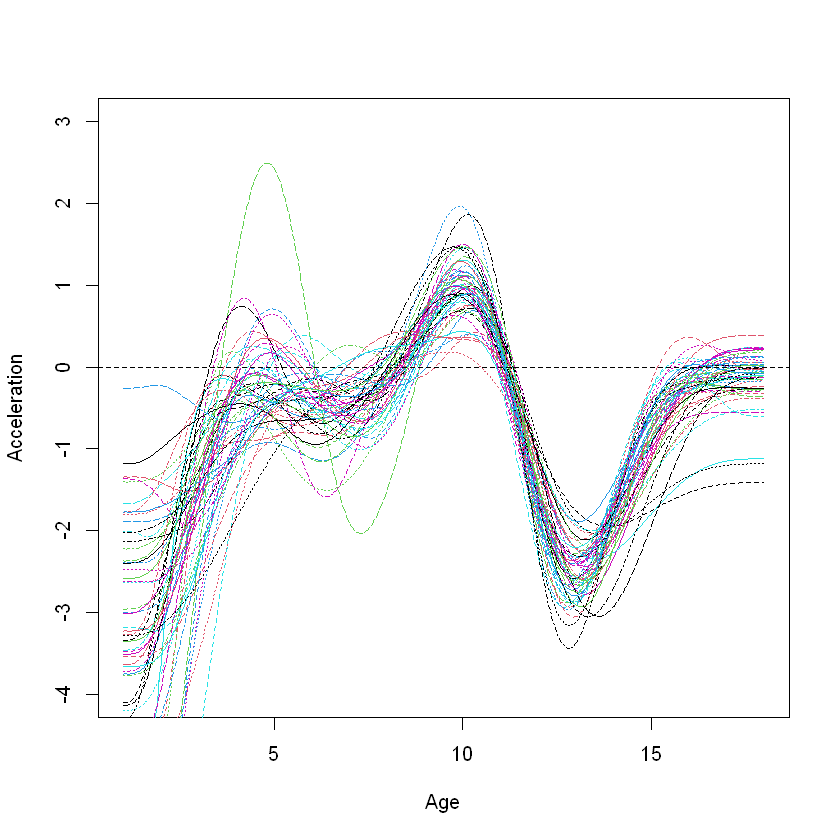

In [20]:
regList = register.fd(yfd=accelUnreg)
accelReg = regList$regfd
# $regfd extracts the registered functions
plot(accelReg, xlab="Age", ylab="Acceleration", ylim=c(-4,3))

In [26]:
warpFunctions = regList$warpfd
# $warpfd extracts the warping functions

APList = AmpPhaseDecomp(xfd=accelUnreg, yfd=accelReg, hfd=warpFunctions)

APList$RSQR
APList$MS.amp
APList$MS.pha

[1] 0.3900564

[1] 5.917822

[1] 3.784422